# Mouse Liver in SpatialData

This notebook is configured for a local SpatialData archive downloaded from the scverse docs. It extracts the bundled `data.zarr` store into a repo-local cache and then opens it with `spatialdata.read_zarr()`.

Configured archive: `/Users/chrislangseth/Downloads/mouse_liver_spatialdata_0.7.1.zip`

In [8]:
from pathlib import Path
import os
import zipfile
from pprint import pprint

import pandas as pd
import spatialdata as sd
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc

In [9]:
ZIP_PATH = Path(os.environ.get("SPATIALDATA_ZIP_PATH", "/Users/chrislangseth/Downloads/mouse_liver_spatialdata_0.7.1.zip"))
EXTRACT_ROOT = Path(os.environ.get("SPATIALDATA_EXTRACT_ROOT", "/Users/chrislangseth/work/karolinska_institutet/projects/KaroSpaceDataWrangling/data/spatialdata_cache/mouse_liver_spatialdata_0_7_1"))
ZARR_PATH = EXTRACT_ROOT / "data.zarr"

ZIP_PATH, EXTRACT_ROOT, ZARR_PATH

(PosixPath('/Users/chrislangseth/Downloads/mouse_liver_spatialdata_0.7.1.zip'),
 PosixPath('/Users/chrislangseth/work/karolinska_institutet/projects/KaroSpaceDataWrangling/data/spatialdata_cache/mouse_liver_spatialdata_0_7_1'),
 PosixPath('/Users/chrislangseth/work/karolinska_institutet/projects/KaroSpaceDataWrangling/data/spatialdata_cache/mouse_liver_spatialdata_0_7_1/data.zarr'))

In [10]:
if not ZIP_PATH.exists():
    raise FileNotFoundError(f"Archive not found: {ZIP_PATH}")

EXTRACT_ROOT.mkdir(parents=True, exist_ok=True)

if not ZARR_PATH.exists():
    with zipfile.ZipFile(ZIP_PATH) as zf:
        members = [name for name in zf.namelist() if name.startswith("data.zarr/")]
        if not members:
            raise ValueError(f"Archive does not contain data.zarr/: {ZIP_PATH}")
        zf.extractall(EXTRACT_ROOT, members=members)
        print(f"Extracted {len(members)} members to {EXTRACT_ROOT}")
else:
    print(f"Using existing extracted store: {ZARR_PATH}")

sdata = sd.read_zarr(ZARR_PATH)

for table in sdata.tables.values():
    table.var_names_make_unique()

sdata

no parent found for <ome_zarr.reader.Label object at 0x377696590>: None


Using existing extracted store: /Users/chrislangseth/work/karolinska_institutet/projects/KaroSpaceDataWrangling/data/spatialdata_cache/mouse_liver_spatialdata_0_7_1/data.zarr


SpatialData object, with associated Zarr store: /Users/chrislangseth/work/karolinska_institutet/projects/KaroSpaceDataWrangling/data/spatialdata_cache/mouse_liver_spatialdata_0_7_1/data.zarr
├── Images
│     └── 'raw_image': DataTree[cyx] (1, 6432, 6432), (1, 1608, 1608)
├── Labels
│     └── 'segmentation_mask': DataArray[yx] (6432, 6432)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 3) (2D points)
├── Shapes
│     └── 'nucleus_boundaries': GeoDataFrame shape: (3375, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (3375, 99)
with coordinate systems:
    ▸ 'global', with elements:
        raw_image (Images), segmentation_mask (Labels), transcripts (Points), nucleus_boundaries (Shapes)

In [11]:
summary = {
    "images": list(sdata.images),
    "labels": list(sdata.labels),
    "points": list(sdata.points),
    "shapes": list(sdata.shapes),
    "tables": list(sdata.tables),
}

pprint(summary)

{'images': ['raw_image'],
 'labels': ['segmentation_mask'],
 'points': ['transcripts'],
 'shapes': ['nucleus_boundaries'],
 'tables': ['table']}


In [12]:
pd.DataFrame(
    [
        {
            "table": name,
            "n_obs": table.n_obs,
            "n_vars": table.n_vars,
            "obs_columns": ", ".join(map(str, table.obs.columns[:12])),
            "var_columns": ", ".join(map(str, table.var.columns[:12])),
            "obsm_keys": ", ".join(map(str, table.obsm_keys())),
        }
        for name, table in sdata.tables.items()
    ]
)

/var/folders/5b/5bpdw2nj10d6gxym7gcl01hh0000gp/T/ipykernel_19035/3778555773.py:9: FutureWarning: Use obsm (e.g. `k in adata.obsm` or `adata.obsm.keys() | {'u'}`) instead of AnnData.obsm_keys, AnnData.obsm_keys is deprecated and will be removed in the future.
  "obsm_keys": ", ".join(map(str, table.obsm_keys())),


,table,n_obs,n_vars,obs_columns,var_columns,obsm_keys
0,table,3375,99,"cell_ID, fov_labels, annotation",,spatial


## Convert To AnnData

The next cell selects a table from the SpatialData object, converts it to an `AnnData` object called `adata`, and ensures `adata.obsm["spatial"]` is present for downstream Scanpy/Squidpy workflows.

Set `SPATIALDATA_TABLE` in the environment if you want to force a specific table name. For the Visium HD archive, the default is `cell_segmentations` when available.


In [13]:
PREFERRED_TABLE = os.environ.get("SPATIALDATA_TABLE")

if PREFERRED_TABLE is not None:
    if PREFERRED_TABLE not in sdata.tables:
        raise KeyError(
            f"Requested table {PREFERRED_TABLE!r} not found. Available tables: {list(sdata.tables)}"
        )
    TABLE_NAME = PREFERRED_TABLE
elif "cell_segmentations" in sdata.tables:
    TABLE_NAME = "cell_segmentations"
elif "table" in sdata.tables:
    TABLE_NAME = "table"
else:
    TABLE_NAME = next(iter(sdata.tables))

adata = sdata.tables[TABLE_NAME].copy()
adata.obs_names_make_unique()
adata.var_names_make_unique()

if "spatial" not in adata.obsm:
    spatial_candidates = [
        ("x", "y"),
        ("X", "Y"),
        ("center_x", "center_y"),
        ("centroid_x", "centroid_y"),
        ("array_col", "array_row"),
        ("pxl_col_in_fullres", "pxl_row_in_fullres"),
    ]
    for x_key, y_key in spatial_candidates:
        if x_key in adata.obs.columns and y_key in adata.obs.columns:
            adata.obsm["spatial"] = adata.obs[[x_key, y_key]].to_numpy()
            break

if "spatial" not in adata.obsm:
    raise ValueError(
        "Could not determine spatial coordinates for `adata`. "
        "Inspect `adata.obs.columns` and `adata.obsm.keys()` to map coordinates explicitly."
    )

adata.uns["spatialdata_source"] = {
    "zip_path": str(ZIP_PATH),
    "zarr_path": str(ZARR_PATH),
    "table_name": TABLE_NAME,
}

print(f"Selected table: {TABLE_NAME}")
print(adata)
print(f"obsm keys: {list(adata.obsm.keys())}")
adata

Selected table: table
AnnData object with n_obs × n_vars = 3375 × 99
    obs: 'cell_ID', 'fov_labels', 'annotation'
    uns: 'annotation_colors', 'spatialdata_attrs', 'spatialdata_source'
    obsm: 'spatial'
obsm keys: ['spatial']


AnnData object with n_obs × n_vars = 3375 × 99
    obs: 'cell_ID', 'fov_labels', 'annotation'
    uns: 'annotation_colors', 'spatialdata_attrs', 'spatialdata_source'
    obsm: 'spatial'

## Basic Processing

This section follows the same general pattern as the existing `cosmx.ipynb` workflow, but uses a standard Scanpy pipeline that should work across these SpatialData-derived `AnnData` objects.


In [14]:
sample_key_candidates = ["sample_id", "library_id", "sample", "fov_labels", "region"]
existing_sample_key = next((key for key in sample_key_candidates if key in adata.obs.columns), None)

if existing_sample_key is None:
    adata.obs["sample_id"] = TABLE_NAME
else:
    adata.obs["sample_id"] = adata.obs[existing_sample_key].astype(str)

adata.obs["sample_id"] = adata.obs["sample_id"].astype("category")
adata

AnnData object with n_obs × n_vars = 3375 × 99
    obs: 'cell_ID', 'fov_labels', 'annotation', 'sample_id'
    uns: 'annotation_colors', 'spatialdata_attrs', 'spatialdata_source'
    obsm: 'spatial'

In [15]:
adata.var["mt"] = adata.var_names.str.upper().str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)

qc_cols = [col for col in ["sample_id", "total_counts", "n_genes_by_counts", "pct_counts_mt"] if col in adata.obs.columns]
adata.obs[qc_cols].head()


,sample_id,total_counts,n_genes_by_counts,pct_counts_mt
0,nucleus_boundaries,33,14,0.0
1,nucleus_boundaries,60,19,0.0
2,nucleus_boundaries,151,11,0.0
3,nucleus_boundaries,109,17,0.0
4,nucleus_boundaries,141,29,0.0


In [16]:
summary_cols = [col for col in ["total_counts", "n_genes_by_counts", "pct_counts_mt"] if col in adata.obs.columns]
(
    adata.obs
    .groupby("sample_id", observed=False)[summary_cols]
    .median()
    .sort_index()
)

,total_counts,n_genes_by_counts,pct_counts_mt
sample_id,,,
nucleus_boundaries,112.0,12.0,0.0


In [17]:
sc.pp.filter_genes(adata, min_counts=3)
sc.pp.filter_cells(adata, min_counts=3)

adata.layers["counts"] = adata.X.copy()

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata.copy()

adata

AnnData object with n_obs × n_vars = 3359 × 98
    obs: 'cell_ID', 'fov_labels', 'annotation', 'sample_id', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_counts'
    uns: 'annotation_colors', 'spatialdata_attrs', 'spatialdata_source', 'log1p'
    obsm: 'spatial'
    layers: 'counts'

In [18]:
n_top_genes = min(2000, adata.n_vars)
sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes, flavor="seurat", subset=True)

sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=min(30, adata.obsm["X_pca"].shape[1]))
sc.tl.umap(adata, min_dist=0.3)
sc.tl.leiden(adata, resolution=1.0, key_added="leiden_1.0")

adata

/Users/chrislangseth/miniforge3/envs/cellcharter/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/5b/5bpdw2nj10d6gxym7gcl01hh0000gp/T/ipykernel_19035/3305339532.py:7: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=1.0, key_added="leiden_1.0")


AnnData object with n_obs × n_vars = 3359 × 98
    obs: 'cell_ID', 'fov_labels', 'annotation', 'sample_id', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden_1.0'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'annotation_colors', 'spatialdata_attrs', 'spatialdata_source', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden_1.0'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

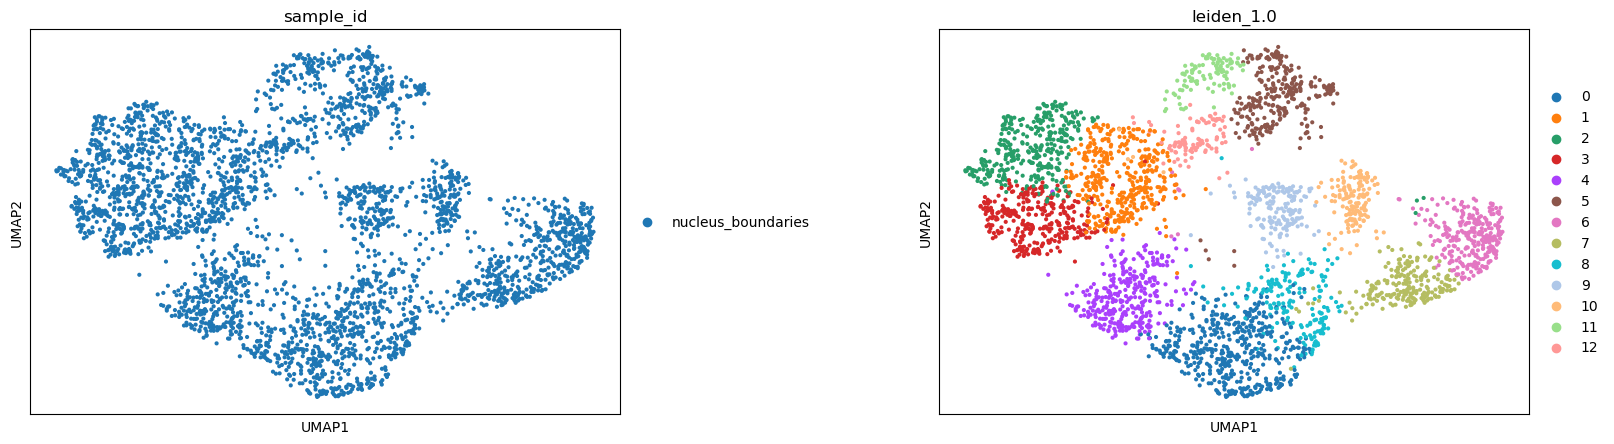

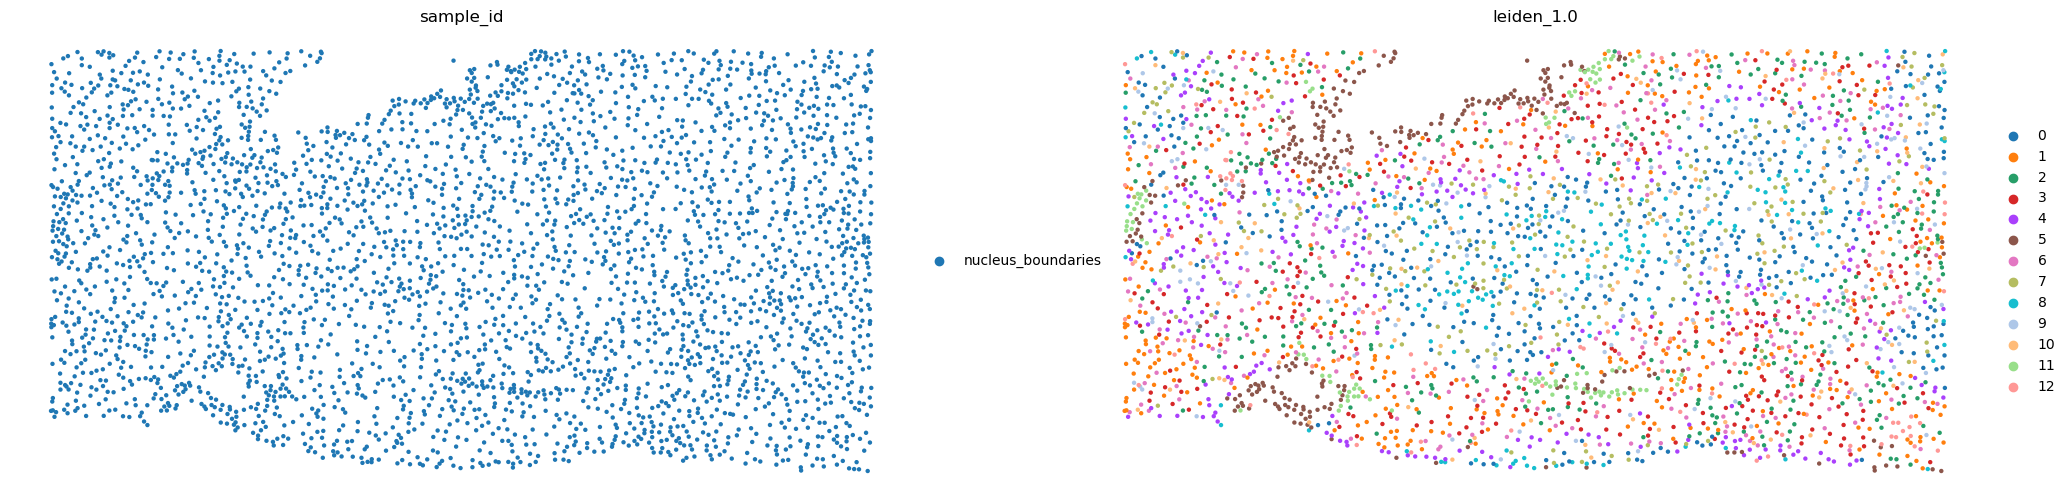

In [22]:
with plt.rc_context({"figure.figsize": (7, 5)}):
    sc.pl.umap(adata, color=["sample_id", "leiden_1.0"], wspace=0.4)

with plt.rc_context({"figure.figsize": (12, 6)}):
    sc.pl.embedding(adata, basis="spatial", color=["sample_id", "leiden_1.0"], s=40, frameon=False)


## Optional Save

Run the next cell if you want a processed `h5ad` written next to the extracted SpatialData cache.


In [ ]:
OUTPUT_H5AD = EXTRACT_ROOT / f"{Path(ZIP_PATH).stem}_{TABLE_NAME}.processed.h5ad"
adata.write_h5ad(OUTPUT_H5AD)
OUTPUT_H5AD

## Optional inspection

Use the next cell to inspect a specific table in detail. This is especially useful for the Visium HD archive, which contains multiple tables.

In [ ]:
table_name = TABLE_NAME
table = adata

print(table_name)
print(table)
table.obs.head()